# OpenPIV first tutorial

Using open source software, OpenPIV (http://www.openpiv.net), written with Python, Numpy, Scipy (http://www.scipy.org), we will introduce the basics of PIV.

This tutorial will follow the simplest analysis path from the two images to the velocity field and some post-analysis.

In [3]:
# import the standard numerical and plotting packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import what is necessary from OpenPIV
from openpiv import tools, pyprocess, validation, filters, scaling

In [4]:
# read a pair of PIV images
frame_a  = tools.imread( './images/exp1_001_b.bmp' )
frame_b  = tools.imread( './images/exp1_001_c.bmp' )

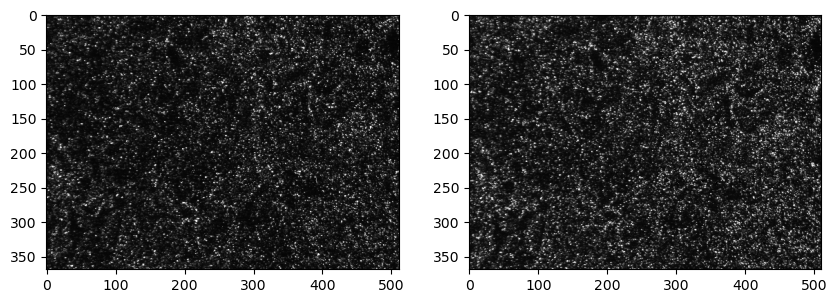

In [5]:
# let's visualize them using matplotlib
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)
plt.show()

## Processing

We are going to use the `extended_search_area_piv function`, wich is a standard PIV cross-correlation algorithm.

This function allows the search area (`search_area_size`) in the second frame to be larger than the interrogation window in the first frame (`window_size`). Also, the search areas can overlap (`overlap`).

The `extended_search_area_piv` function will return three arrays:
1. The `u` component of the velocity field
2. The `v` component of the velocity field
3. The signal-to-noise ratio (`sig2noise`) of the cross-correlation map of each vector. The higher the signal-to-noise ratio, the higher the probability that its magnitude and direction are correct.

In [6]:
# define the PIV analysis parameters
winsize = 24 # size of the interrogation window in frame A, in pixels
searchsize = 32  # size of the window in frame B (searchsize is larger or equal to winsize), in pixels
overlap = 12 # overlap between the neighbouring windows, in pixels
dt = 0.02 # time interval of the PIV recording, in sec

In [7]:
u, v, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

The function `get_coordinates` finds the center of each interrogation window. This will be useful later on when plotting the vector field.

In [8]:
# get a list of coordinates for the vector field
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

## Post-processing

Strictly speaking, we are ready to plot the vector field. However, some spurious vectors might locally impact the quality of the results. It might therefore be useful to apply some filtering. 

To start, let's use the function `sig2noise_val` to get a mask indicating which vectors have a minimum amount of signal-to-noise ratio. Vectors below a certain threshold are substituted by `NaN`. If you are not sure about which threshold value to use, try taking a look at the signal-to-noise ratio histogram with: `plt.hist(sig2noise.flatten())`.

In [9]:
# clean the peaks that are below a quality threshold
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = 1.3,
)

Another useful function is `replace_outliers`, which will find outlier vectors and substitute them with an average of neighboring vectors. The larger the `kernel_size`, the larger the considered neighborhood. This function uses an iterative image inpainting algorithm. The number of iterations can be chosen via `max_iter`.

In [10]:
# replace those that are masked as bad vectors with local interpolation
u, v = filters.replace_outliers(
    u, v,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

Next, we are going to convert pixels to millimeters.

In [11]:
# scale the results from pix/dt to mm/sec
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 ) # 96.52 pixels/millimeter

## Plot and save the results

The vector field can be plotted with `display_vector_field`. Vectors with signal-to-noise ratio below the threshold are displayed in red.

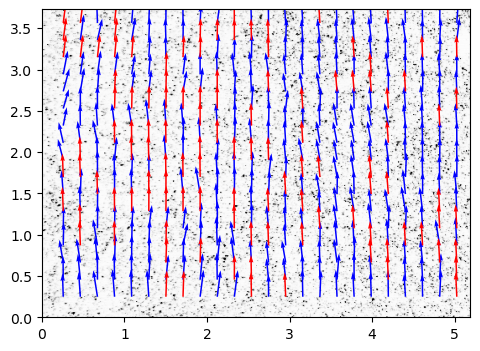

In [12]:
import pathlib

fig, ax = plt.subplots(figsize=(9,4))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'),
    ax=ax, scaling_factor=96.52,
    scale=50, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str('./images/exp1_001_b.bmp'),
)
plt.show()

The function `save` is used to save the vector field to a ASCII tabular file.

In [13]:
tools.save('exp1_001.txt' , x, y, u, v, invalid_mask)

# Another example
## Use any pair of images that you can access via URL
For instance we can use images from PIV Challenge http://www.pivchallenge.org/

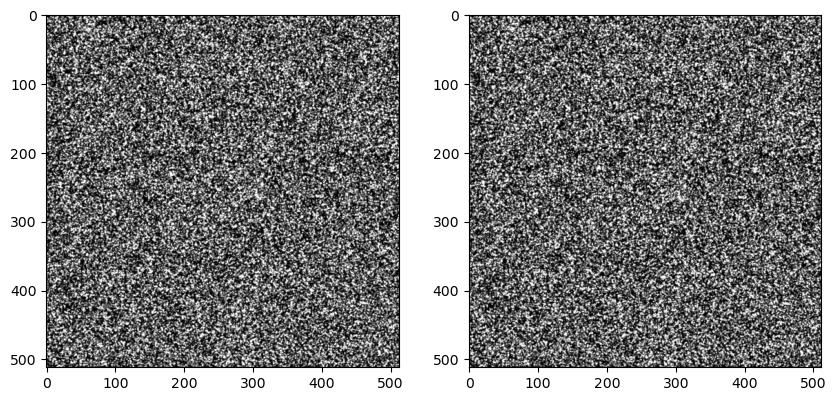

In [12]:
frame_a = tools.imread('http://www.pivchallenge.org/pub/B/B001_1.tif')
frame_b = tools.imread('http://www.pivchallenge.org/pub/B/B001_2.tif')
#frame_a = tools.imread("./images/B005_1.tif")
#frame_b = tools.imread("./images/B005_2.tif")
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)
plt.show()

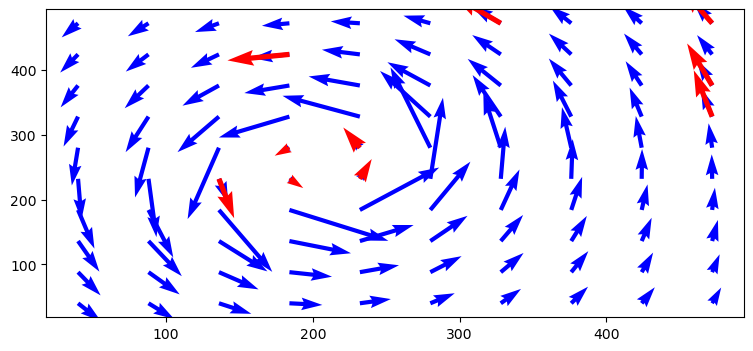

In [13]:
winsize = 32 # pixels
searchsize = 64  # pixels, search in image B
overlap = 16 # pixels
dt = 1.0 # sec
u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
#x, y = pyprocess.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)
#u, v, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.1 )
#u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
#Post-processing
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = 1.1,
)

u, v = filters.replace_outliers(
    u, v,
    invalid_mask,
    method='localmean',
    max_iter=10,
    kernel_size=2,
)
# x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

plt.figure(figsize=(9,4))
plt.quiver(x,y,u,v,color='b')
plt.quiver(x[invalid_mask],y[invalid_mask],u[invalid_mask],v[invalid_mask],color='r')
plt.show()